Walk trees part 2: walks and selections
----------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)
- Written: 1.2020
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/petgraph-fsm) [ipynb](./walk-trees-part2-walks.ipynb)

Walk trees are a novel algorithm for selecting regions of graphs.

I'll start my descriptiobn of this algorithm by showing you how to use the `petgraph-overlay` library to select/extract a region from a graph.

In [2]:
:dep petgraph-examples = {path="./petgraph-examples"}

In [3]:
:dep petgraph = {path="./petgraph"}

In [4]:
:dep petgraph-overlay = {path="./petgraph-overlay"}

In [5]:
:dep petgraph-evcxr = {path="./petgraph-evcxr"}

In [6]:
:dep petgraph-fsm = {path="./petgraph-fsm", features=["evcxr", "select"]}

In [7]:
use std::collections::HashMap;
use petgraph::*;
use petgraph::graph::*;
use petgraph::data::*;
use petgraph_overlay::*;
use petgraph_evcxr::*;
use petgraph_examples::*;

In [8]:
use petgraph_examples as examples;
use petgraph::visit::IntoNodeReferences;
extern crate petgraph;
let dwc = examples::directed_graph_with_cycle();

If I have a graph.

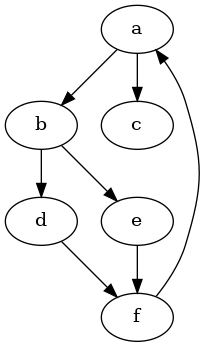

In [9]:
draw_graph(&dwc);

And I want to select a region of this graph, for example nodes 'a' and 'b' and the vertex that goes between them. I can do so as so and use built in functionality to display that selection.

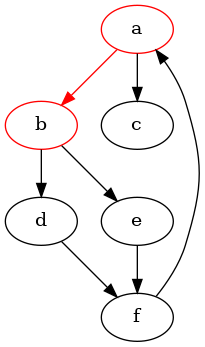

In [10]:

fn ex1<'a>(dwc: &'a Graph<String, String, petgraph::Directed>){
    let mut selection = Selection::new(&dwc);
    selection.select_node(node_index(0));
    selection.select_edge(dwc.edge_references().next().unwrap());
    selection.select_node(node_index(1));
    selection.draw_overlayed();
}
ex1(&dwc);

I can also extract that region of the graph.

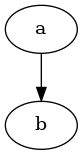

In [11]:
fn ex2<'a>(dwc: &'a Graph<String, String, petgraph::Directed>){
    let mut selection = Selection::new(&dwc);
    selection.select_node(node_index(0));
    selection.select_edge(dwc.edge_references().next().unwrap());
    selection.select_node(node_index(1));
    let overlayed_elements = selection.overlayed_elements();
    let extracted_selection: Graph<String, String, petgraph::Directed> = Graph::from_elements(overlayed_elements);
    draw_graph(&extracted_selection);
}
ex2(&dwc);

Now lets move on to walks.

I'll start by copying from the excelent [d3 graph theory](https://d3gt.com/unit.html?walk) tutorial.

```
Walk is sequence of adjacent vertices (or edges) in a graph.
```

If we have a graph like:

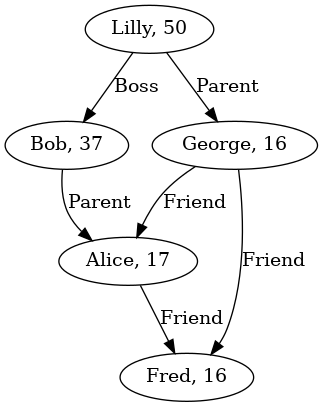

In [15]:
let sg = social();
{
    draw_graph(&sg);
}

We can walk along this graph, staring at `Lilly, 50` and going `Boss` → `Parent` → `Friend` like so:

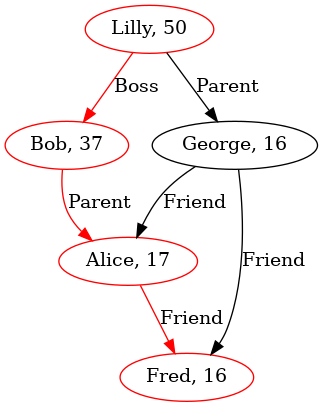

In [16]:
use petgraph_fsm::select::*;
{
    let mut ws = WalkingSelector::new(
        &sg,
        Person { name: "Lilly".to_string(), age: 50 },
        &|ew1, ew2| {
            if ew1 == ew2 {Some(())} else {None}
        },
    ).unwrap();
    ws.next(Relationship::Boss);
    ws.next(Relationship::Parent);
    ws.next(Relationship::Friend);
    ws.get_selection().draw_overlayed();
}

So that's a walk, and it lets us select regions of a graph from a center node. It doesn't seem very useful yet, but we're not done. The name of the algorithm is "walk trees". In the most basic sense, a walk-tree is a walk, but rather than being a list of edges or vertex's it is a tree of adjacent edges or vertex's.

For example, if we can construct a "walk tree" starting at `Lilly, 50` going simultaneously to both `Boss` and `Parent` then from `Boss` to `Parent`.

```
Lilly, 50
    Boss
        Parent
    Parent
```

In order to select the following region of the graph:

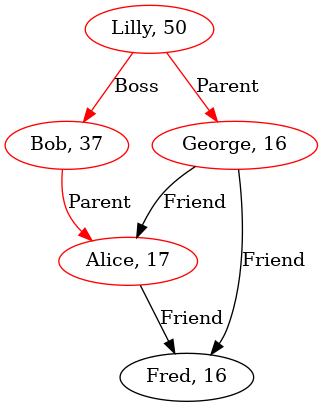

In [22]:
{
    let mut selection = Selection::new(&sg);
    let mut nrs = sg.edge_references();
    selection.select_node(node_index(0));
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(1));
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(2));
    nrs.next();
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(3));
    let overlayed_elements = selection.overlayed_elements();
    selection.draw_overlayed();
}

Walk tree's work best for selecting regions when they are autmatically pruned if they contain edges that are not in the underlying graph. For example if we have a walk tree:

```
Lilly, 50
    Boss
        Parent
    Parent
    Friend
```

It will evaluate to the same region as

```
Lilly, 50
    Boss
        Parent
    Parent
```

When applied to the above graph. The `Friend` edge will be ignored as `Lilly` has no friends.

Furthemore, it is sometimes useful to apply walk trees 'nondeterministically' [1]. That is, if we apply 

```
Lilly, 50
    Boss
        Parent
    Parent
        Friend
```

We usually want to select both `Friend` edges comming out of `George`.

[1]  Don't be confused by my use of the term `non-deterministic` here. This does not that we role a pair of dice to determine which edge to go down, but rather that we go down both edges at the same time. Don't blame me. Blame [Rabin and Scott](https://en.wikipedia.org/wiki/Nondeterministic_finite_automaton).

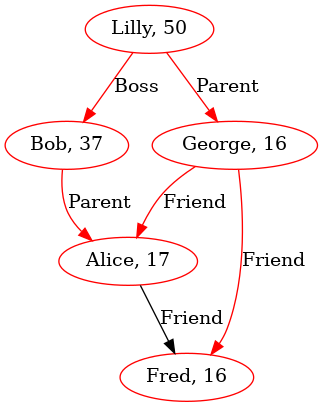

In [24]:
{
    let mut selection = Selection::new(&sg);
    let mut nrs = sg.edge_references();
    selection.select_node(node_index(0));
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(1));
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(2));
    selection.select_edge(nrs.next().unwrap());
    selection.select_edge(nrs.next().unwrap());
    selection.select_node(node_index(3));
    selection.select_edge(nrs.next().unwrap());
    nrs.next();
    selection.select_node(node_index(4));
    let overlayed_elements = selection.overlayed_elements();
    selection.draw_overlayed();
}

In that case, all of the graph but one edge is selected by the 'nondeterministic' walk tree.

Again I'll copy from the [d3 graph theory](https://d3gt.com/unit.html?open-vs-closed) tutorial.

There are also some special kinds of walks that will come in handy in the near future.

```
Trail is an open walk where vertices can repeat, but not edges.

Path is an open walk with no repetition of vertices and edges.

If you make a trail (or path) closed by coinciding the terminal vertices, then what you end up with is called a circuit (or cycle).

Circuit is a closed walk where vertices can repeat, but not edges.

Cycle is a closed walk where neither vertices nor edges can repeat. But since it is closed, the first and the last vertices are the same (one repetition).
```